In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-11-20 09:45:31.954266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763631932.140125      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763631932.189662      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Jumlah sample test: 61
Device: cuda


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


Model loaded: /kaggle/input/model_seg_brain_vessel/pytorch/default/1/model.pt


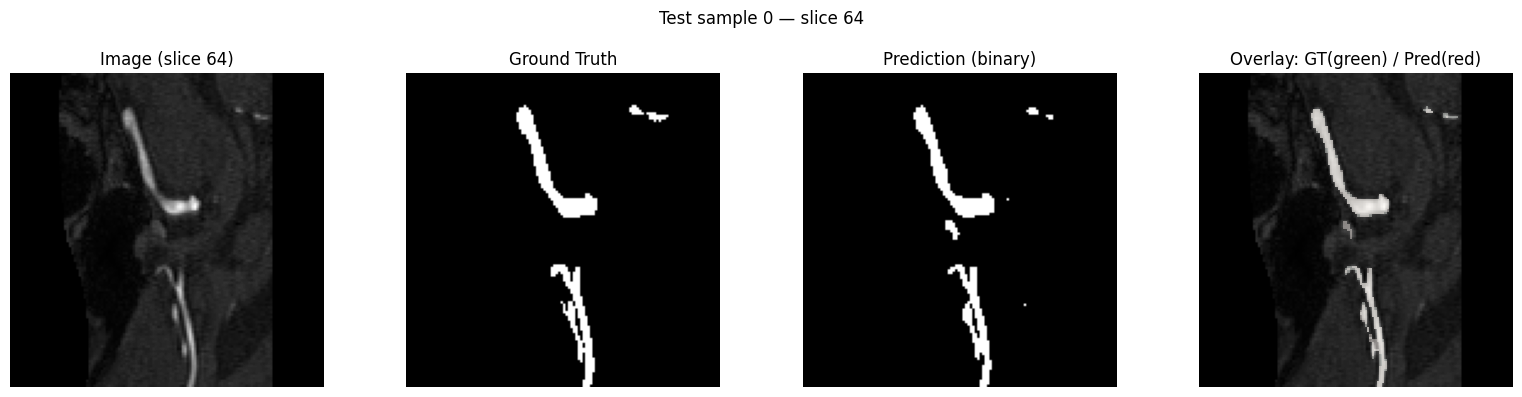

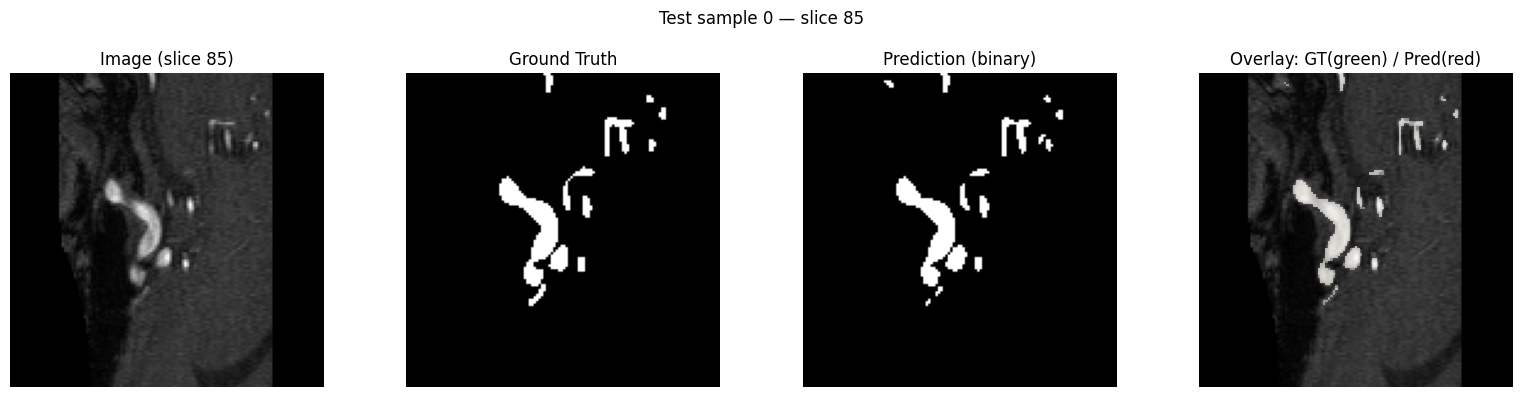

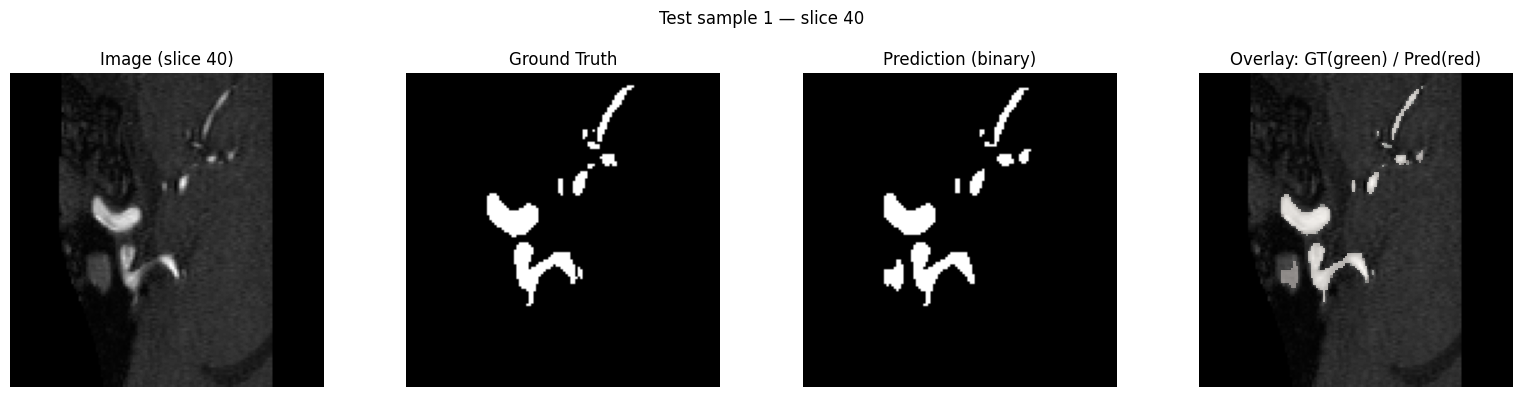

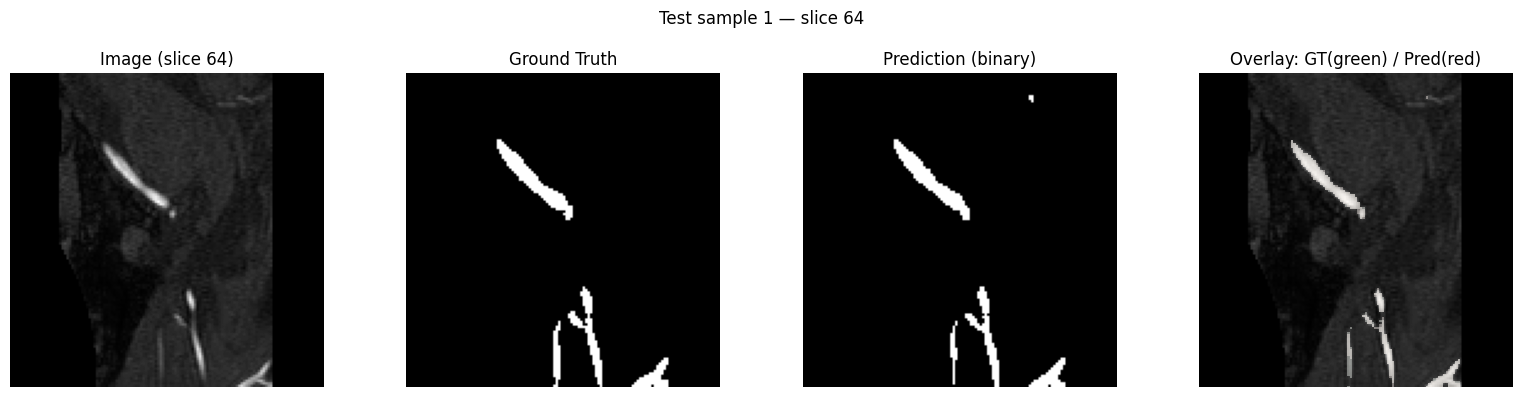

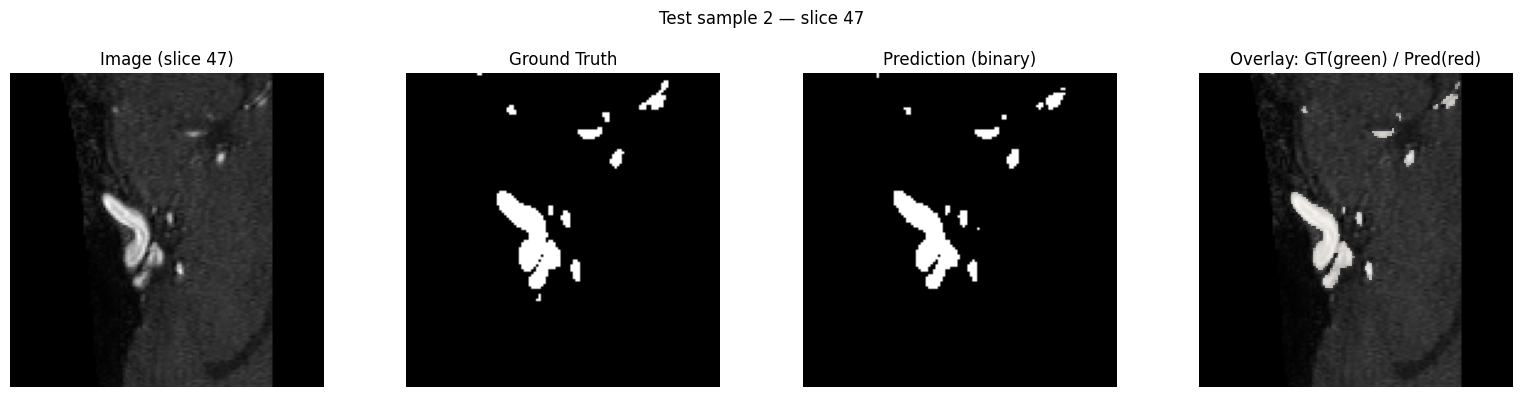

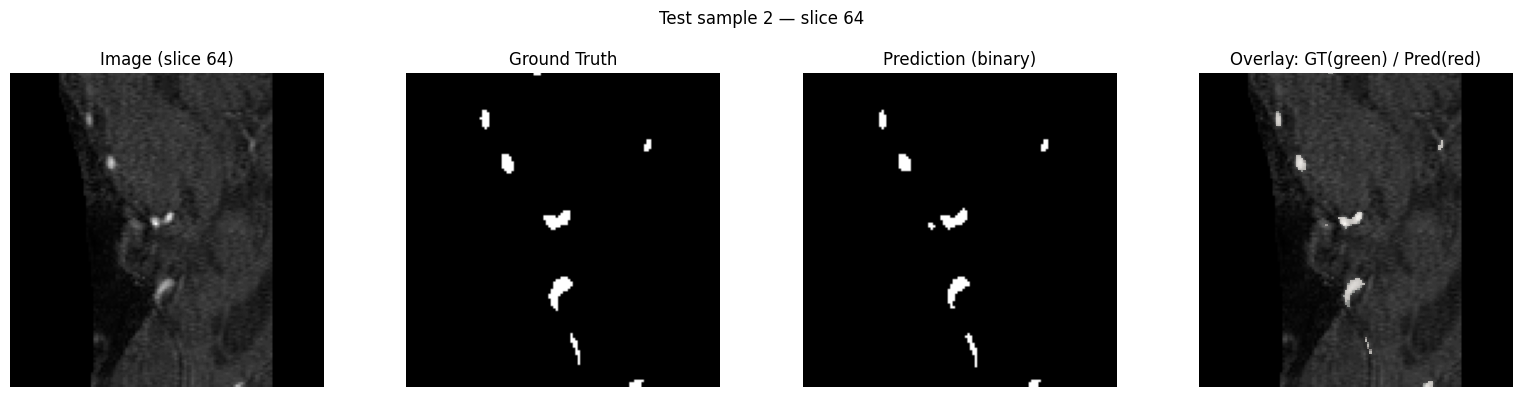


Aggregated Test Metrics (mean across volumes):
Dice: 0.9144 (n=3)
IoU: 0.8425 (n=3)
Accuracy: 0.9971 (n=3)
Precision: 0.9266 (n=3)
Recall: 0.9026 (n=3)
F1: 0.9144 (n=3)

Prediksi nifti disimpan di: /kaggle/working/predictions
Visualisasi disimpan di: /kaggle/working/predictions_vis


In [ ]:

import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
    ResizeWithPadOrCropd, NormalizeIntensityd, ToTensord
)
from monai.data import Dataset as MonaiDataset
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score


image_test_dir = "/kaggle/input/costa-adam/imagesTs"   
label_test_dir = "/kaggle/input/costa-adam/labelsTs"   
model_path = "/kaggle/input/model_seg_brain_vessel/pytorch/default/1/model.pt"                
out_pred_dir = "/kaggle/working/predictions"           
vis_dir = "/kaggle/working/predictions_vis"           
batch_size = 1
input_size = (128, 128, 128)   
threshold = 0.5
num_vis = 3                    


os.makedirs(out_pred_dir, exist_ok=True)
os.makedirs(vis_dir, exist_ok=True)


def list_nii_files(folder):
    files = [f for f in os.listdir(folder) if (f.endswith(".nii") or f.endswith(".nii.gz"))]
    files = sorted(files)
    return [os.path.join(folder, f) for f in files]

test_paths = list_nii_files(image_test_dir)
label_test_paths = list_nii_files(label_test_dir)

if len(test_paths) == 0:
    raise FileNotFoundError(f"Tidak menemukan file nii di {image_test_dir}")
if len(label_test_paths) == 0:
    raise FileNotFoundError(f"Tidak menemukan file nii di {label_test_dir}")
if len(test_paths) != len(label_test_paths):
    print("Peringatan: jumlah image dan label test berbeda. Akan meng-zip sampai panjang minimum.")
min_len = min(len(test_paths), len(label_test_paths))
test_paths = test_paths[:min_len]
label_test_paths = label_test_paths[:min_len]

print(f"Jumlah sample test: {len(test_paths)}")


test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),              
    EnsureChannelFirstd(keys=["image", "label"]),    
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=input_size),
    NormalizeIntensityd(keys="image"),
    ToTensord(keys=["image", "label"])
])

test_dicts = [{"image": img, "label": lbl} for img, lbl in zip(test_paths, label_test_paths)]
test_ds = MonaiDataset(test_dicts, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file tidak ditemukan di {model_path}. Pastikan file ada.")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Model loaded:", model_path)


test_metrics = {"Dice": [], "IoU": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []}

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        x = batch["image"].to(device)        
        
        orig_img_path = test_paths[i]
        orig_affine = nib.load(orig_img_path).affine

        pred = sliding_window_inference(x, roi_size=input_size, sw_batch_size=1, predictor=model)
        pred_np = torch.sigmoid(pred).cpu().numpy()      
        pred_np = pred_np[0, 0]                          
        pred_bin = (pred_np > threshold).astype(np.uint8)

        save_path = os.path.join(out_pred_dir, f"prediction_{i}.nii.gz")
        nib.save(nib.Nifti1Image(pred_bin.astype(np.uint8), affine=orig_affine), save_path)

        
        y_true = batch["label"].cpu().numpy()[0, 0].astype(np.uint8).flatten()
        y_pred_flat = pred_bin.flatten()

        
        try:
            test_metrics["Dice"].append(f1_score(y_true, y_pred_flat, zero_division=0))
            test_metrics["IoU"].append(jaccard_score(y_true, y_pred_flat, zero_division=0))
            test_metrics["Accuracy"].append(accuracy_score(y_true, y_pred_flat))
            test_metrics["Precision"].append(precision_score(y_true, y_pred_flat, zero_division=0))
            test_metrics["Recall"].append(recall_score(y_true, y_pred_flat, zero_division=0))
            test_metrics["F1"].append(f1_score(y_true, y_pred_flat, zero_division=0))
        except Exception as e:
            print(f"Error menghitung metrik untuk sample {i}: {e}")
        
        image_vol = batch["image"].cpu().numpy()[0, 0]  
        label_vol = batch["label"].cpu().numpy()[0, 0]  

        mid_slice_idx = image_vol.shape[0] // 2
        slice_sums = pred_bin.sum(axis=(1, 2))
        max_slice_idx = int(np.argmax(slice_sums)) if slice_sums.sum() > 0 else mid_slice_idx
        slices_to_show = sorted(set([mid_slice_idx, max_slice_idx]))

        for s_idx in slices_to_show:
            img_slice = image_vol[s_idx]
            lbl_slice = label_vol[s_idx]
            prd_slice = pred_bin[s_idx]

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            axes[0].imshow(img_slice, cmap="gray")
            axes[0].set_title(f"Image (slice {s_idx})")
            axes[0].axis("off")

            axes[1].imshow(lbl_slice, cmap="gray")
            axes[1].set_title("Ground Truth")
            axes[1].axis("off")

            axes[2].imshow(prd_slice, cmap="gray")
            axes[2].set_title("Prediction (binary)")
            axes[2].axis("off")

            axes[3].imshow(img_slice, cmap="gray")
            axes[3].imshow(np.ma.masked_where(lbl_slice == 0, lbl_slice), cmap="Greens", alpha=0.4)
            axes[3].imshow(np.ma.masked_where(prd_slice == 0, prd_slice), cmap="Reds", alpha=0.4)
            axes[3].set_title("Overlay: GT(green) / Pred(red)")
            axes[3].axis("off")

            plt.suptitle(f"Test sample {i} — slice {s_idx}")
            plt.tight_layout(rect=[0, 0, 1, 0.95])

            out_path = os.path.join(vis_dir, f"test_{i}_slice_{s_idx}.png")
            plt.savefig(out_path, bbox_inches="tight", dpi=150)
            plt.show()
            plt.close(fig)

        
        if num_vis > 0 and i + 1 >= num_vis:
            break


print("\nAggregated Test Metrics (mean across volumes):")
for k, v in test_metrics.items():
    if len(v) > 0:
        print(f"{k}: {np.mean(v):.4f} (n={len(v)})")
    else:
        print(f"{k}: - (no data)")

print(f"\nPrediksi nifti disimpan di: {out_pred_dir}")
print(f"Visualisasi disimpan di: {vis_dir}")

File label ditemukan: /kaggle/input/costa-adam/labelsTs/10001-TOF_ADAM.nii
Memuat dan mentransformasi data...
Data loaded dan ditransformasi.
Device: cuda


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


Model loaded: /kaggle/input/model_seg_brain_vessel/pytorch/default/1/model.pt
Menjalankan inference untuk 10001-TOF_ADAM...
Prediksi nifti disimpan di: /kaggle/working/predictions_single/prediction_10001-TOF_ADAM.nii.gz
Label ditemukan. Menghitung metrik dan membuat visualisasi 4-panel...

Metrics for this file:
  Dice (F1): 0.9185
  IoU (Jaccard): 0.8494
  Accuracy: 0.9969
  Precision: 0.9308
  Recall: 0.9066


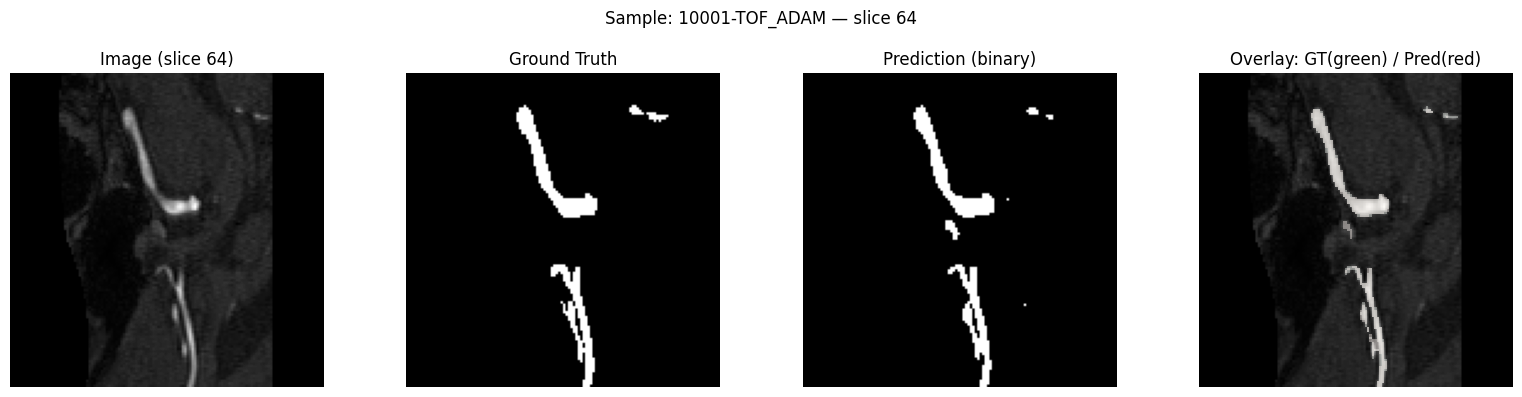

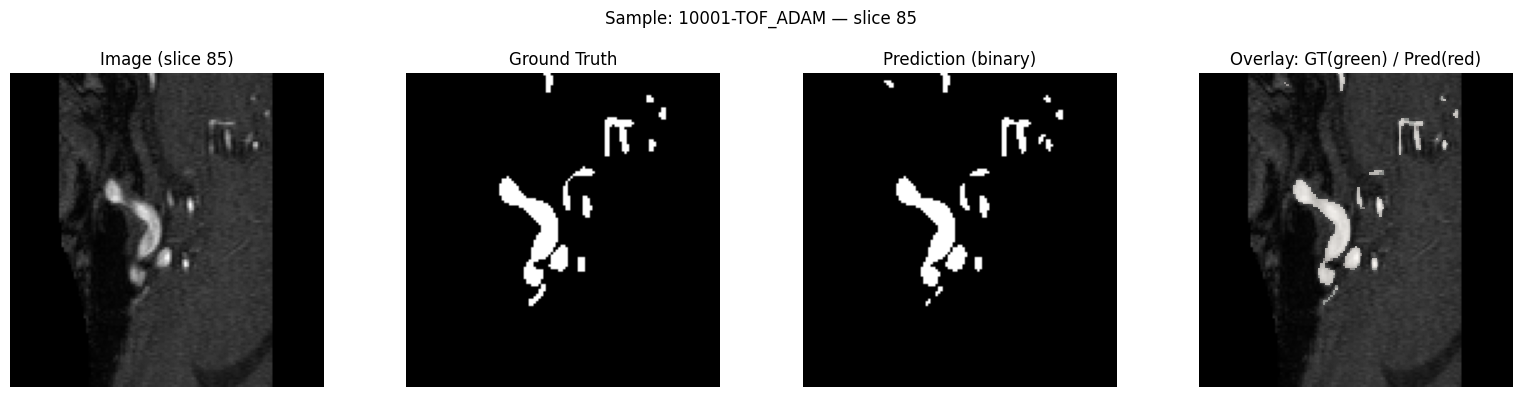

Visualisasi (4-panel) disimpan di: /kaggle/working/predictions_vis_single

Selesai.


In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
    ResizeWithPadOrCropd, NormalizeIntensityd, ToTensord
)
from monai.data import Dataset as MonaiDataset
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

image_file_path = "/kaggle/input/costa-adam/imagesTs/10001-TOF_ADAM.nii"
label_file_path = "/kaggle/input/costa-adam/labelsTs/10001-TOF_ADAM.nii"
model_path = "/kaggle/input/model_seg_brain_vessel/pytorch/default/1/model.pt"

out_pred_dir = "/kaggle/working/predictions_single"        
vis_dir = "/kaggle/working/predictions_vis_single"        
input_size = (128, 128, 128)
threshold = 0.5


os.makedirs(out_pred_dir, exist_ok=True)
os.makedirs(vis_dir, exist_ok=True)

if not os.path.exists(image_file_path):
    raise FileNotFoundError(f"File image tidak ditemukan di {image_file_path}")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file tidak ditemukan di {model_path}. Pastikan file ada.")

transform_keys = ["image", "label"]

test_transforms = Compose([
    LoadImaged(keys=transform_keys, allow_missing_keys=True), 
    EnsureChannelFirstd(keys=transform_keys, allow_missing_keys=True),
    Orientationd(keys=transform_keys, axcodes="RAS", allow_missing_keys=True),
    ResizeWithPadOrCropd(keys=transform_keys, spatial_size=input_size, allow_missing_keys=True),
    NormalizeIntensityd(keys="image"), 
    ToTensord(keys=transform_keys, allow_missing_keys=True)
])

data_dict = {"image": image_file_path}

if label_file_path:
    if not os.path.exists(label_file_path):
        print(f"Peringatan: File label {label_file_path} tidak ditemukan. Melanjutkan tanpa label.")
        label_file_path = None
    else:
        data_dict["label"] = label_file_path
        print(f"File label ditemukan: {label_file_path}")
else:
     print("Tidak ada file label. Hanya akan melakukan prediksi (tanpa metrik/overlay GT).")

print("Memuat dan mentransformasi data...")
try:
    transformed_data = test_transforms(data_dict)
    print("Data loaded dan ditransformasi.")
except Exception as e:
    print(f"Error saat memuat/transformasi data: {e}")
    if label_file_path:
        print("Mencoba lagi tanpa label...")
        label_file_path = None
        data_dict.pop("label", None)
        test_transforms = Compose([
            LoadImaged(keys="image"),
            EnsureChannelFirstd(keys="image"),
            Orientationd(keys="image", axcodes="RAS"),
            ResizeWithPadOrCropd(keys="image", spatial_size=input_size),
            NormalizeIntensityd(keys="image"),
            ToTensord(keys="image")
        ])
        transformed_data = test_transforms(data_dict)
        print("Data loaded (hanya image).")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Model loaded:", model_path)


with torch.no_grad():

    x = transformed_data["image"].unsqueeze(0).to(device)

    orig_affine = nib.load(image_file_path).affine

    base_name = os.path.basename(image_file_path).split('.')[0]

    print(f"Menjalankan inference untuk {base_name}...")
    
    pred = sliding_window_inference(x, roi_size=input_size, sw_batch_size=1, predictor=model)
    pred_np = torch.sigmoid(pred).cpu().numpy()      
    pred_np = pred_np[0, 0]                       
    pred_bin = (pred_np > threshold).astype(np.uint8)

    save_path = os.path.join(out_pred_dir, f"prediction_{base_name}.nii.gz")
    nib.save(nib.Nifti1Image(pred_bin.astype(np.uint8), affine=orig_affine), save_path)
    print(f"Prediksi nifti disimpan di: {save_path}")

    image_vol = transformed_data["image"].cpu().numpy()[0] 

    mid_slice_idx = image_vol.shape[0] // 2
    slice_sums = pred_bin.sum(axis=(1, 2))
    max_slice_idx = int(np.argmax(slice_sums)) if slice_sums.sum() > 0 else mid_slice_idx
    slices_to_show = sorted(set([mid_slice_idx, max_slice_idx]))

    if label_file_path and "label" in transformed_data:
        print("Label ditemukan. Menghitung metrik dan membuat visualisasi 4-panel...")
        
        
        label_vol = transformed_data["label"].cpu().numpy()[0] 
        y_true = label_vol.astype(np.uint8).flatten()
        y_pred_flat = pred_bin.flatten()
        
        
        try:
            dice = f1_score(y_true, y_pred_flat, zero_division=0)
            iou = jaccard_score(y_true, y_pred_flat, zero_division=0)
            accuracy = accuracy_score(y_true, y_pred_flat)
            precision = precision_score(y_true, y_pred_flat, zero_division=0)
            recall = recall_score(y_true, y_pred_flat, zero_division=0)
            
            print("\nMetrics for this file:")
            print(f"  Dice (F1): {dice:.4f}")
            print(f"  IoU (Jaccard): {iou:.4f}")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")

        except Exception as e:
            print(f"Error menghitung metrik: {e}")

        
        for s_idx in slices_to_show:
            img_slice = image_vol[s_idx]
            lbl_slice = label_vol[s_idx]
            prd_slice = pred_bin[s_idx]

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            axes[0].imshow(img_slice, cmap="gray")
            axes[0].set_title(f"Image (slice {s_idx})")
            axes[0].axis("off")

            axes[1].imshow(lbl_slice, cmap="gray")
            axes[1].set_title("Ground Truth")
            axes[1].axis("off")

            axes[2].imshow(prd_slice, cmap="gray")
            axes[2].set_title("Prediction (binary)")
            axes[2].axis("off")

            axes[3].imshow(img_slice, cmap="gray")
            axes[3].imshow(np.ma.masked_where(lbl_slice == 0, lbl_slice), cmap="Greens", alpha=0.4)
            axes[3].imshow(np.ma.masked_where(prd_slice == 0, prd_slice), cmap="Reds", alpha=0.4)
            axes[3].set_title("Overlay: GT(green) / Pred(red)")
            axes[3].axis("off")

            plt.suptitle(f"Sample: {base_name} — slice {s_idx}")
            plt.tight_layout(rect=[0, 0, 1, 0.95])

            out_path = os.path.join(vis_dir, f"vis_{base_name}_slice_{s_idx}.png")
            plt.savefig(out_path, bbox_inches="tight", dpi=150)
            plt.show()
            plt.close(fig)
        
        print(f"Visualisasi (4-panel) disimpan di: {vis_dir}")

    else:
        
        print("Label tidak ditemukan. Membuat visualisasi 3-panel...")

        for s_idx in slices_to_show:
            img_slice = image_vol[s_idx]
            prd_slice = pred_bin[s_idx]

            fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
            axes[0].imshow(img_slice, cmap="gray")
            axes[0].set_title(f"Image (slice {s_idx})")
            axes[0].axis("off")

            axes[1].imshow(prd_slice, cmap="gray")
            axes[1].set_title("Prediction (binary)")
            axes[1].axis("off")

            axes[2].imshow(img_slice, cmap="gray")
            axes[2].imshow(np.ma.masked_where(prd_slice == 0, prd_slice), cmap="Reds", alpha=0.5) 
            axes[2].set_title("Overlay: Pred(red)")
            axes[2].axis("off")

            plt.suptitle(f"Sample: {base_name} — slice {s_idx}")
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            
            out_path = os.path.join(vis_dir, f"vis_{base_name}_slice_{s_idx}.png")
            plt.savefig(out_path, bbox_inches="tight", dpi=150)
            plt.show()
            plt.close(fig)

        print(f"Visualisasi (3-panel) disimpan di: {vis_dir}")

print("\nSelesai.")